# Notebook zum Hauptteil: _Network Modeling_

In diesem Notebook werden die Co-Autorenschaften basierend auf den Publikationsdaten mit den wichtigsten Zentralitätsmaßen ausgewertet und visualisiert. 

Die Daten der Co-Autor:innen werden aus dem PubMed-Datensatz genommen. Die Zwischenauswertung ist unten zu finden. 

### Quellen 
Drei zentrale Quellen für den folgenden Teil waren: 
- Off. Dokumentation von networkx und pyvis: https://networkx.org/documentation/stable/index.html | https://pyvis.readthedocs.io/en/latest/documentation.html
- GitHub Repo von thu-vu92 mit einer Beispielmodellierung: https://github.com/thu-vu92/the_witcher_network 
- Monographie: Platt, E. L. (2019). Network science with Python and NetworkX quick start guide. Packt. https://portal.igpublish.com/iglibrary/search/PACKT0005243.html
- Stellen, an denen KI genutzt wurde, sind mit **[KI]** markiert und suchbar


In [1]:
# Import der nötigen Bibliotheken 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from pathlib import Path 
import networkx as nx 
from networkx.algorithms import community
from pyvis.network import Network  
from pathlib import Path
import os 
import ast
import datetime 

# Aktuelles Datum definieren 
datum = datetime.datetime.now().strftime("%d.%m.%y")

# Pfade definieren 
base_dir = Path.cwd().parent
pi_data = base_dir / "01_data" / "01_csv_data" / "00_pi_basics" 
network_dir = base_dir / "01_data" / "05_network"
pubs_dir = base_dir / "01_data" / "01_csv_data" / "99_pubmed"

In [2]:
# Datenvorverarbeitung für alle Co-Autorenschaften  
folder = pubs_dir 

# Erstellung einer Liste, die alle Dateipfade entält
list_a = [x for x in folder.glob("*.csv")]
print("Anzahl der Dateien im Publikationsunterordner insgesamt = {}.\n".format(len(list_a)))

# Erstellung einer Liste, die alle Df-Objekte enthält L
df_list = [pd.read_csv(x, encoding="utf-8") for x in list_a]

# Erstellung eines finalen Df mit allen Datensätzen 
df_all = pd.concat(df_list, axis=0, ignore_index=True)
print("\nVergleich des Umfangs der Einzeldateien zur Gesamtdatei:")
print(f"Länge Einzeldateien: {sum([len(x) for x in df_list])}", "\n", f"Länge Gesamtdatei: {len(df_all)}")
print(70*"==")

# Daten inspizieren
print(f" Spalten Gesamtdatei: {df_all.columns}")
print(70*"==")
print(df_all.info())
print(70*"==")
#print(df_all.head())
#print(70*"==")

#pd.set_option("display.max_colwidth", 1000)
#print(df_all["co_authors"])
#print(70*"==")

# PI-Namen hashen 
df_pi = pd.read_csv(pi_data / "FINALLY_ALL_pi_data.csv", encoding="utf-8")
pi_name_map = dict(zip(df_pi["nachname"], df_pi["pi_name_hashed"]))
df_all["source_hashed"] = df_all["source"].map(pi_name_map)

# Gruppierung 
df_all_agg = df_all.groupby("source_hashed")["title"].count().sort_values(ascending=False)
print("Erste Einsicht in die Verteilungsstruktur der Coautorenschaften nach PI:")
df_all_agg = df_all_agg.reset_index().rename(columns={"source_hashed": "PI", "title": "co_author_count"})
print(f"Anzahl der Publikationen insgesamt PI: {df_all_agg["co_author_count"].sum()}\n")
print(df_all_agg)
print(70*"==")

Anzahl der Dateien im Publikationsunterordner insgesamt = 43.


Vergleich des Umfangs der Einzeldateien zur Gesamtdatei:
Länge Einzeldateien: 1564 
 Länge Gesamtdatei: 1564
 Spalten Gesamtdatei: Index(['source', 'title', 'keywords', 'publication_date', 'co_authors',
       'abstract', 'Unnamed: 0', 'paper_id', 'citation_count'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   source            1564 non-null   object 
 1   title             1553 non-null   object 
 2   keywords          1538 non-null   object 
 3   publication_date  1564 non-null   object 
 4   co_authors        1564 non-null   object 
 5   abstract          1515 non-null   object 
 6   Unnamed: 0        72 non-null     float64
 7   paper_id          72 non-null     object 
 8   citation_count    72 non-null     float64
dtypes: float64(2), obje

In [3]:
# Die Co-Autoren-Spalte in einen eigenen Df transformieren 

# Liste für die Co-Autoren definieren 
# Anm.: Die PIs des Fachbereichs sind auch hier gehasht! 
all = [] 

for row in df_all[["source_hashed", "source", "co_authors"]].itertuples(index=False):
    pi_name = row.source_hashed 
    authors_list = row.co_authors
    authors_list_l = ast.literal_eval(authors_list)
    df = pd.json_normalize(authors_list_l) 
    df.insert(0, "source_hashed", pi_name)
    df.insert(1, "source", row.source)
    all.append(df)

final = pd.concat(all, axis=0, ignore_index=True) 
#print(final.head(50)) 
#print(f"\n {final.shape}")
#print(f"\n {final.columns}")

# Aggregieren und Ergebnisse ansehen
df_agg = final.groupby("source_hashed")["lastname"].count().sort_values(ascending=False)
print("Erste Übersicht der aggregierten Daten zu der Anzahl der Co-Autoren:\n")
print(df_agg.head(10))
print(90*"==")
print("Übersicht zum finalen Dataframe:")
print(final[["source_hashed", "lastname"]].head())

Erste Übersicht der aggregierten Daten zu der Anzahl der Co-Autoren:

source_hashed
YQdO6    946
3uQdV    846
Nx/ca    679
TqX2v    678
RI2M5    660
EtGNI    611
5Tu5C    555
bb6hC    480
aEfGQ    465
ReZBo    356
Name: lastname, dtype: int64
Übersicht zum finalen Dataframe:
  source_hashed lastname
0         trU3e       Su
1         trU3e    Huang
2         trU3e     Peng
3         trU3e   Amunts
4         trU3e     Yang


In [4]:
# Internationalität als neue Spalte integrieren 

import pycountry

country_names = [country.name for country in pycountry.countries] 
#print(country_names)

# Leere Spalte initiieren 
final["international"] = None

for x in country_names:
    if x.lower() != "germany": 
        matches = final["affiliation"].str.lower().str.contains(x.lower(), na=False, regex=False)
        final.loc[matches, "international"] = x.lower()

#print(final.columns, "\n\n", final.head(5))
#print(90*"==")
final_agg2 = final.groupby("source_hashed")["international"].count().sort_values(ascending=False)
print("Übersicht zur Anzahl in den internationalen Co-Autorenschaften nach PI:")
print(final_agg2)
print(80*"=")
final_agg3 = final["international"].value_counts()
print("Übersicht zu den verschiedenen Ländern in ihrer Anazhl:")
print(final_agg3)



Übersicht zur Anzahl in den internationalen Co-Autorenschaften nach PI:
source_hashed
RI2M5    286
EtGNI    269
YQdO6    234
aEfGQ    230
oAWW9    188
Nx/ca    176
3uQdV    165
5Tu5C    139
ReZBo    126
mGDUj    116
TqX2v     82
Aqpgt     80
Tm1F5     80
0nT+q     58
PfQWz     57
30BPQ     57
M4aTQ     56
sPQN4     56
VCK7S     55
nKxeh     44
BiBfk     41
bb6hC     40
D5nMm     30
GJBPu     29
7Alx+     29
8w/Fs     25
Fv5CN     24
Lt4od     22
XTXqt     20
trU3e     20
26Iam     19
20K6v     18
uDuyU     17
+w0gG     16
ztE5N     15
PscCy     11
Gpy08      5
7ohzq      3
41vAp      2
+3h6+      2
+DEav      0
1EFmI      0
6Vx1g      0
Name: international, dtype: int64
Übersicht zu den verschiedenen Ländern in ihrer Anazhl:
international
france                311
china                 292
italy                 197
switzerland           184
japan                 180
                     ... 
thailand                1
cuba                    1
jamaica                 1
albania          

## Erstellung des finalen Df für die Netzwerkmodellierung

In [5]:
# Finaler Df für Netzwerkmodellierung 

# Der Df basiert auf den PIs in dem Feature "source_hashed" und den Co-Autor*innen aus dem Feature "lastname"
final_nx = final[["source_hashed", "source", "lastname"]]

# Erstellen eines gruppierten Df, um die gemeinsamen Publikationen zu zählen
final_nx_agg = final_nx.groupby(["source", "lastname"]).size().reset_index(name="counts")
# Filtern des Df danach, dass die selbstreferenziellen Einträge entfernt werden
final_nx_agg = final_nx_agg[final_nx_agg["source"] != final_nx_agg["lastname"]]

# Sortierung der Werte nach der Anzahl 
final_nx_agg = final_nx_agg.sort_values("counts", ascending=False)

# Checks der Ergebnisse 
print("Final aggregierten Dataframe für die Netzwerkmodellierung:\n")
print(final_nx_agg)
print(80*"=")
print("Länge des Dataframes:")
print(len(final_nx_agg))
print(80*"=")

Final aggregierten Dataframe für die Netzwerkmodellierung:

            source    lastname  counts
5261       Sachser      Kaiser      45
3154        Kaiser     Sachser      45
3148        Kaiser     Richter      40
5283       Sachser     Richter      38
1387    Finkemeier      Eirich      38
...            ...         ...     ...
12          Amunts     Nystedt       1
6318  von Schaewen      Eirich       1
6319  von Schaewen      Elting       1
6320  von Schaewen    Feussner       1
6321  von Schaewen  Finkemeier       1

[6317 rows x 3 columns]
Länge des Dataframes:
6317


In [6]:

# Deduplizieren der PIs/Nodes nach alphabetischer Sortierung, da für alle PIs die Paare (A, B) - (B, A) vorkommen  
# Quelle: Dieses Verfahren ist gut bei thu-vu92 beschrieben. 

index_löschen = []
durchlaufen = set()

for row in final_nx_agg.itertuples():
    aktuelle_reihe = tuple(sorted([str(row.source), str(row.lastname)]))
    if aktuelle_reihe in durchlaufen:
        index_löschen.append(row.Index)
    else:
        durchlaufen.add(aktuelle_reihe)

# Entfernen der Doppelungen nach Index 
final_nx_agg_clean = final_nx_agg.drop(index_löschen)

#Leere Spalte erstellen
final_nx_agg_clean["institute"] = None 
for i, row2 in final_nx_agg_clean.iterrows():
    for row1 in df_pi.itertuples():        
        if row2["source"] in row1.nachname:
            final_nx_agg_clean.at[i, "institute"] = row1.institute
            break

# Farben zur optischen Institutsdiffernzierung hinzufügen
colors = {
    "invb":"#cd001a", 
    "immb":"#ef6a00", 
    "ieb":"#f2cd00",
    "ibbp":"#79c300", 
    "iizp":"#1961ae",
    "zdb":"#61007d"
}

# Hinzufügen der Farbcodes in den Df
final_nx_agg_clean["colors"] = final_nx_agg_clean["institute"].map(colors)

# Checks 
print("Anzahl der Personen pro Institut:")
print(final_nx_agg_clean.groupby("institute")["source"].nunique())
print(80*"=")
print(f"Gelöschte Zeilen: {len(index_löschen)}")
print(80*"=")
print("Finaler Dataframe -- ohne Duplikate:")
print(final_nx_agg_clean)
print(80*"=")
print("Länge des finalen Dataframe:")
print(len(final_nx_agg_clean))
print(80*"=")

Anzahl der Personen pro Institut:
institute
ibbp    10
ieb      9
iizp     8
immb     6
invb     8
Name: source, dtype: int64
Gelöschte Zeilen: 42
Finaler Dataframe -- ohne Duplikate:
             source       lastname  counts institute   colors
5261        Sachser         Kaiser      45      invb  #cd001a
3148         Kaiser        Richter      40      invb  #cd001a
5283        Sachser        Richter      38      invb  #cd001a
1387     Finkemeier         Eirich      38      ibbp  #79c300
4301  Moerschbacher  Cord-Landwehr      36      ibbp  #79c300
...             ...            ...     ...       ...      ...
20           Amunts             Su       1      ibbp  #79c300
12           Amunts        Nystedt       1      ibbp  #79c300
6318   von Schaewen         Eirich       1      ibbp  #79c300
6319   von Schaewen         Elting       1      ibbp  #79c300
6320   von Schaewen       Feussner       1      ibbp  #79c300

[6275 rows x 5 columns]
Länge des finalen Dataframe:
6275


In [7]:
print(final_nx_agg_clean["institute"].value_counts())

institute
ibbp    2275
ieb     1529
iizp     925
invb     896
immb     650
Name: count, dtype: int64


In [8]:
# Plotting mit pyvis und networkx

# Initialisierung des Graphenobjektes 
G = nx.from_pandas_edgelist(final_nx_agg_clean, 
							source="source",
							target="lastname", 
							edge_attr="counts", 
							create_using=nx.Graph())

# Node/Edge Attributes setzen
for node in G.nodes():
    G.nodes[node]["label"] = str(node)
    G.nodes[node]["font"] = {"size": 30, "color": "black"}
for u, v, data in G.edges(data=True):
    count_val = data.get("counts", "N/A")

# Graphen initialisieren mit pyvis
net = Network(notebook=True, width="100%", height="700px", bgcolor="#22222", font_color="black", 
              filter_menu=True, select_menu=True, cdn_resources="remote")

# Größe und Farbe der Nodes nach Institut festlegen, um Vernetzung anzuzeigen 
node_degree = dict(G.degree)
#print(dict(G.degree))
nx.set_node_attributes(G, node_degree, "size")

node_color = final_nx_agg_clean.set_index("source").to_dict()["colors"]
nx.set_node_attributes(G, node_color, "color")
#print(node_color)

In [9]:
# Graphen nur nach internen PIs filtern, da der Gesamtgraph zu umfangreich ist (über 6000 Nodes), um anschaulich zu sein

only_pis = [*node_color.keys()]

G_subset = G.subgraph(only_pis).copy()

# Anonymisierung der Nodes 
G_subset = nx.relabel_nodes(G_subset, pi_name_map)

In [10]:
# Graphen bauen und anzeigen lassen 
# [KI]: Gerade für die Interaktivitätseinstellungen waren die Tipps von Copilot sehr hilfreich! Und trotzdem: 
# der Plot funktioniert nur bedingt, die Fehlersuche wurde vorerst aufgegeben, auch weil andere, statische Plots 
# ausreichend sind. 

net.from_nx(G_subset)  # vorher einfach G, aber mit über 6000 Nodes zu groß! 

# Optionen einstellen, um die Interaktiv nutzerfreundlich zu gestalten mit wenig Dynamik und mehr Abständen zwischen den Nodes 
try: 
    net.force_atlas_2based(
        gravity=-480,         
        central_gravity=0.005,
        spring_length=500,    
        spring_strength=0.04, 
        damping=0.9,          
        overlap=1             
    )

    net.toggle_physics(True)
    net.show_buttons(filter_=["physics", "nodes", "edges", "interaction"])

    net.write_html(str(network_dir / f"network_pis_interactive_{datum}.html"))

except Exception as e: 
    print(f"Fehler bei der Erstellung des interaktiven Plots mit Pyvis: {e}")


## Basale Metriken auswerten

Eine zentrale Quelle für den folgenden Abschnitt waren die DataCamp Kurse [Introduction to Network Analysis in Python](https://www.datacamp.com/courses/introduction-to-network-analysis-in-python) und [Intermediate Network Analysis in Python](https://www.datacamp.com/courses/intermediate-network-analysis-in-python).

In [23]:
print("Übersicht Node Attribute:")
print(list(G_subset.nodes(data=True))[:1]) 
print(120*"=")
print("Übersicht Edge Attribute:")
print(list(G_subset.edges(data=True))[:1])
print(120*"=")
print(f"Anzahl der Nodes: {len(G_subset.nodes())}")
print(120*"=")
print(f"Anzahl der Edges: {len(G_subset.edges())}")
print(120*"=")

# Zentrale Metriken auswerten

print("Centrality Degree Metric, sortiert: (Wie zentral ist jemand basierend auf der Anzahl an Edges)")
cgm = dict(sorted(nx.degree_centrality(G_subset).items(), key=lambda item: item[1], reverse=True))
cgm_df = pd.DataFrame.from_dict(cgm, orient="index", columns=["degree_centrality"]).reset_index().rename(columns={"index": "PI"})
print(cgm_df.head(10))
print(120*"=")
print("Betweenness Metric, sortiert: (Wie oft liegt ein Node auf dem kürzesten Weg zwischen zwei anderen)") 
bcm = dict(sorted(nx.betweenness_centrality(G_subset).items(), key=lambda item: item[1], reverse=True))
bcm_df = pd.DataFrame.from_dict(bcm, orient="index", columns=["betweenness_centrality"]).reset_index().rename(columns={"index": "PI"})
print(bcm_df.head(10), "\n")
print(120*"=")
print("Closeness Metric, sortiert: (Wie nah liegt ein Node an allen anderen)")
ccm = dict(sorted(nx.closeness_centrality(G_subset).items(), key=lambda item: item[1], reverse=True))
ccm_df = pd.DataFrame.from_dict(ccm, orient="index", columns=["closeness_centrality"]).reset_index().rename(columns={"index": "PI"})
print(ccm_df.head(10), "\n")
print(120*"=")
print("Density des Netzwerks:")
print(nx.density(G_subset))
print(120*"=")

# Communities und Cliques ermitteln
communities = community.louvain_communities(G_subset, weight="weight", seed=42)

# Maximale Cliques finden 
cliques = list(nx.find_cliques(G_subset))
cliques_df = pd.DataFrame(cliques)
print(cliques_df)
print(120*"=")
largest_clique = max(cliques, key=len)

cliques_min_three = [x for x in cliques if len(x) >= 3]

print(f"Alle Cliques: (wo jeder Node mit jedem anderen verbunden ist -- ab einer Größe von 3): {len(cliques_min_three)}\n", 
      cliques_min_three)
print(120*"=")
print("Größte Clique:\n", largest_clique)
print(120*"=")

Übersicht Node Attribute:
[('20K6v', {'label': 'Wicke', 'font': {'size': 30, 'color': 'black'}, 'size': 35, 'color': '#f2cd00'})]
Übersicht Edge Attribute:
[('20K6v', '41vAp', {'counts': 4, 'width': 1})]
Anzahl der Nodes: 41
Anzahl der Edges: 93
Centrality Degree Metric, sortiert: (Wie zentral ist jemand basierend auf der Anzahl an Edges)
      PI  degree_centrality
0  41vAp              0.475
1  RI2M5              0.275
2  7Alx+              0.250
3  30BPQ              0.250
4  bb6hC              0.250
5  Aqpgt              0.250
6  3uQdV              0.250
7  Nx/ca              0.225
8  20K6v              0.175
9  EtGNI              0.150
Betweenness Metric, sortiert: (Wie oft liegt ein Node auf dem kürzesten Weg zwischen zwei anderen)
      PI  betweenness_centrality
0  41vAp                0.307584
1  RI2M5                0.154891
2  3uQdV                0.114926
3  Aqpgt                0.114028
4  XTXqt                0.096667
5  7Alx+                0.076484
6  Nx/ca             

In [12]:
# Speichern der Ergebnisse 

df_metrics = pd.DataFrame({
    "degree_centrality": dict(nx.degree_centrality(G_subset)),
    "betweenness_centrality": dict(nx.betweenness_centrality(G_subset)),
    "closeness_centrality": dict(nx.closeness_centrality(G_subset))
})

df_metrics.to_csv(network_dir / f"network_metrics_pis_{datum}.csv", encoding="utf-8", index_label="pi_name_hashed")
df_metrics.to_excel(network_dir / f"network_metrics_pis_{datum}.xlsx", engine="openpyxl", index_label="pi_name_hashed")

# Cliques speichern 
df_cliques = pd.DataFrame({"cliques": cliques})
df_cliques.to_csv(network_dir / f"network_cliques_pis_{datum}.csv", encoding="utf-8", index_label="clique_id")
df_cliques.to_excel(network_dir / f"network_cliques_pis_{datum}.xlsx", engine="openpyxl", index_label="clique_id")

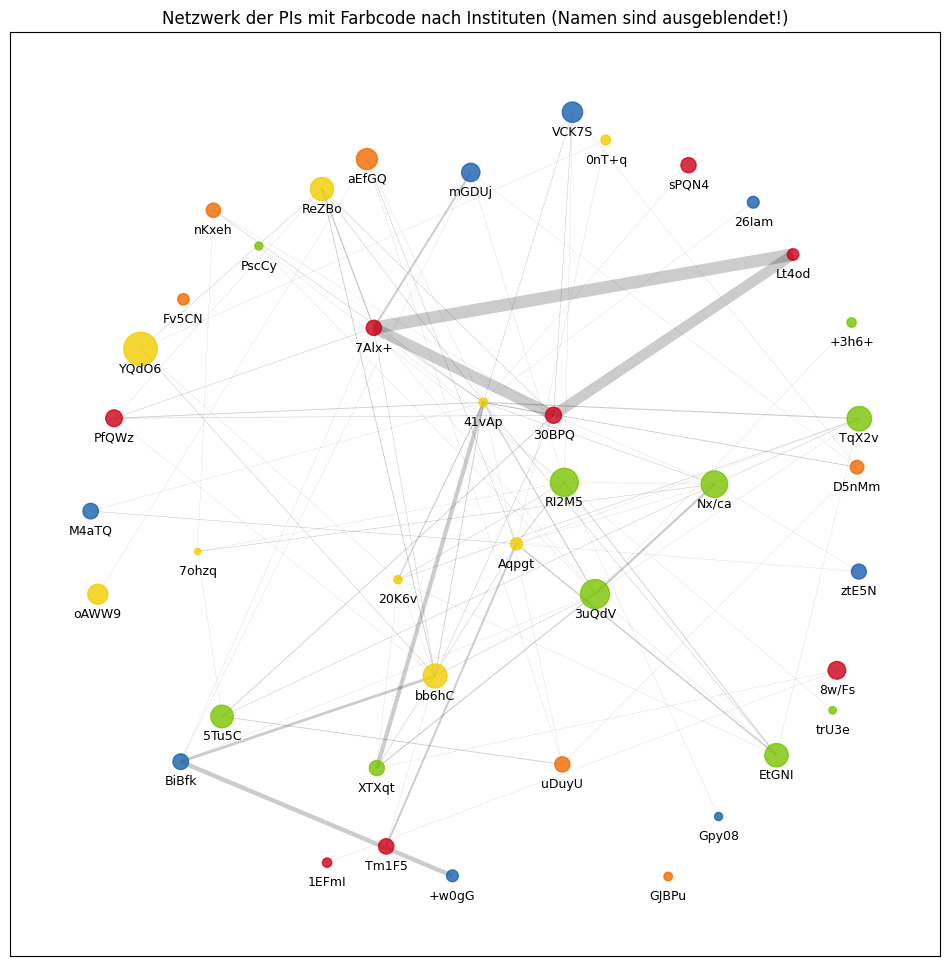

In [13]:
# Weiteren Graphen erstellen, der nicht interaktiv ist 

plt.figure(figsize=(12, 12)) 

# Die verschiedenen Attribute ziehen und in den Graphen übergeben 
sizes  = [data["size"] for _, data in G_subset.nodes(data=True)]
colors = [data["color"] for _, data in G_subset.nodes(data=True)]
widths = [data["counts"] / 5 for _, _, data in G_subset.edges(data=True)]

pos = nx.spring_layout(G_subset, k=1.7, iterations=50) 
nx.draw_networkx_nodes(G_subset, pos, node_size=sizes, node_color=colors, alpha=0.8)
nx.draw_networkx_edges(G_subset, pos, width=widths, alpha=0.2)
label_pos = {node: (x, y-0.05) for node, (x, y) in pos.items()}
nx.draw_networkx_labels(G_subset, label_pos, font_size=9)
plt.title("Netzwerk der PIs mit Farbcode nach Instituten (Namen sind ausgeblendet!)")
plt.savefig(str(network_dir / f"network_pis_static_{datum}.png"), dpi=300)
plt.show()


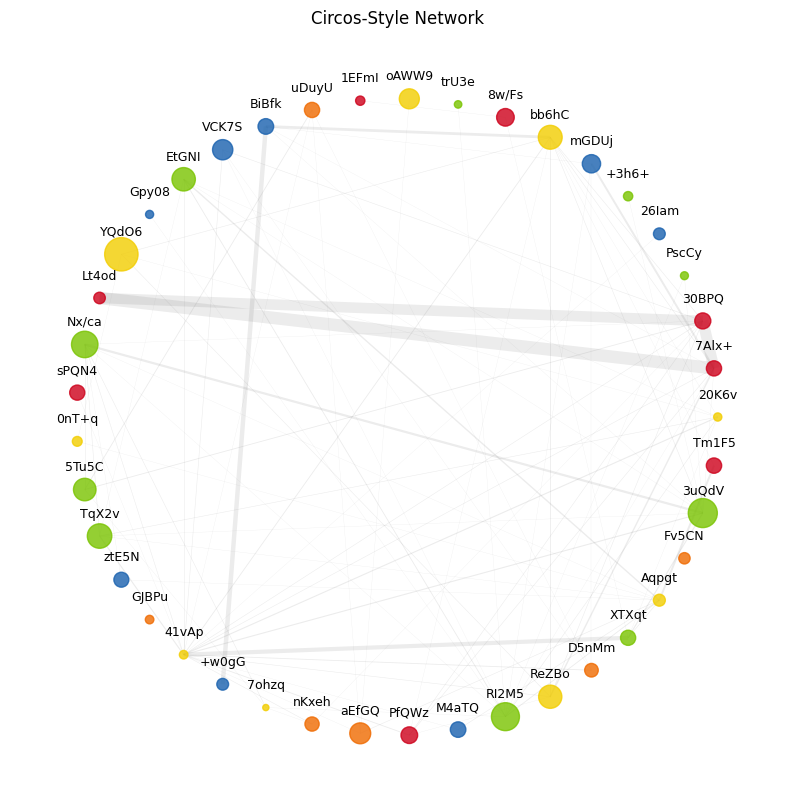

In [14]:
# Circos Plot erstellen
n = len(G_subset.nodes())
theta = np.linspace(0, 2*np.pi, n, endpoint=False)
pos_circos = {node: (np.cos(t), np.sin(t)) for node, t in zip(G_subset.nodes(), theta)}

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G_subset, pos_circos, node_size=sizes, node_color=colors, alpha=0.8)
nx.draw_networkx_edges(G_subset, pos_circos, width=widths, alpha=0.15, edge_color='gray')
label_pos = {node: (x, y+0.07) for node, (x, y) in pos_circos.items()}
nx.draw_networkx_labels(G_subset, label_pos, font_size=9)
plt.title("Circos-Style Network")
plt.axis("off")
plt.savefig(str(network_dir / f"network_pis_circos_{datum}.png"), dpi=300)
plt.show()


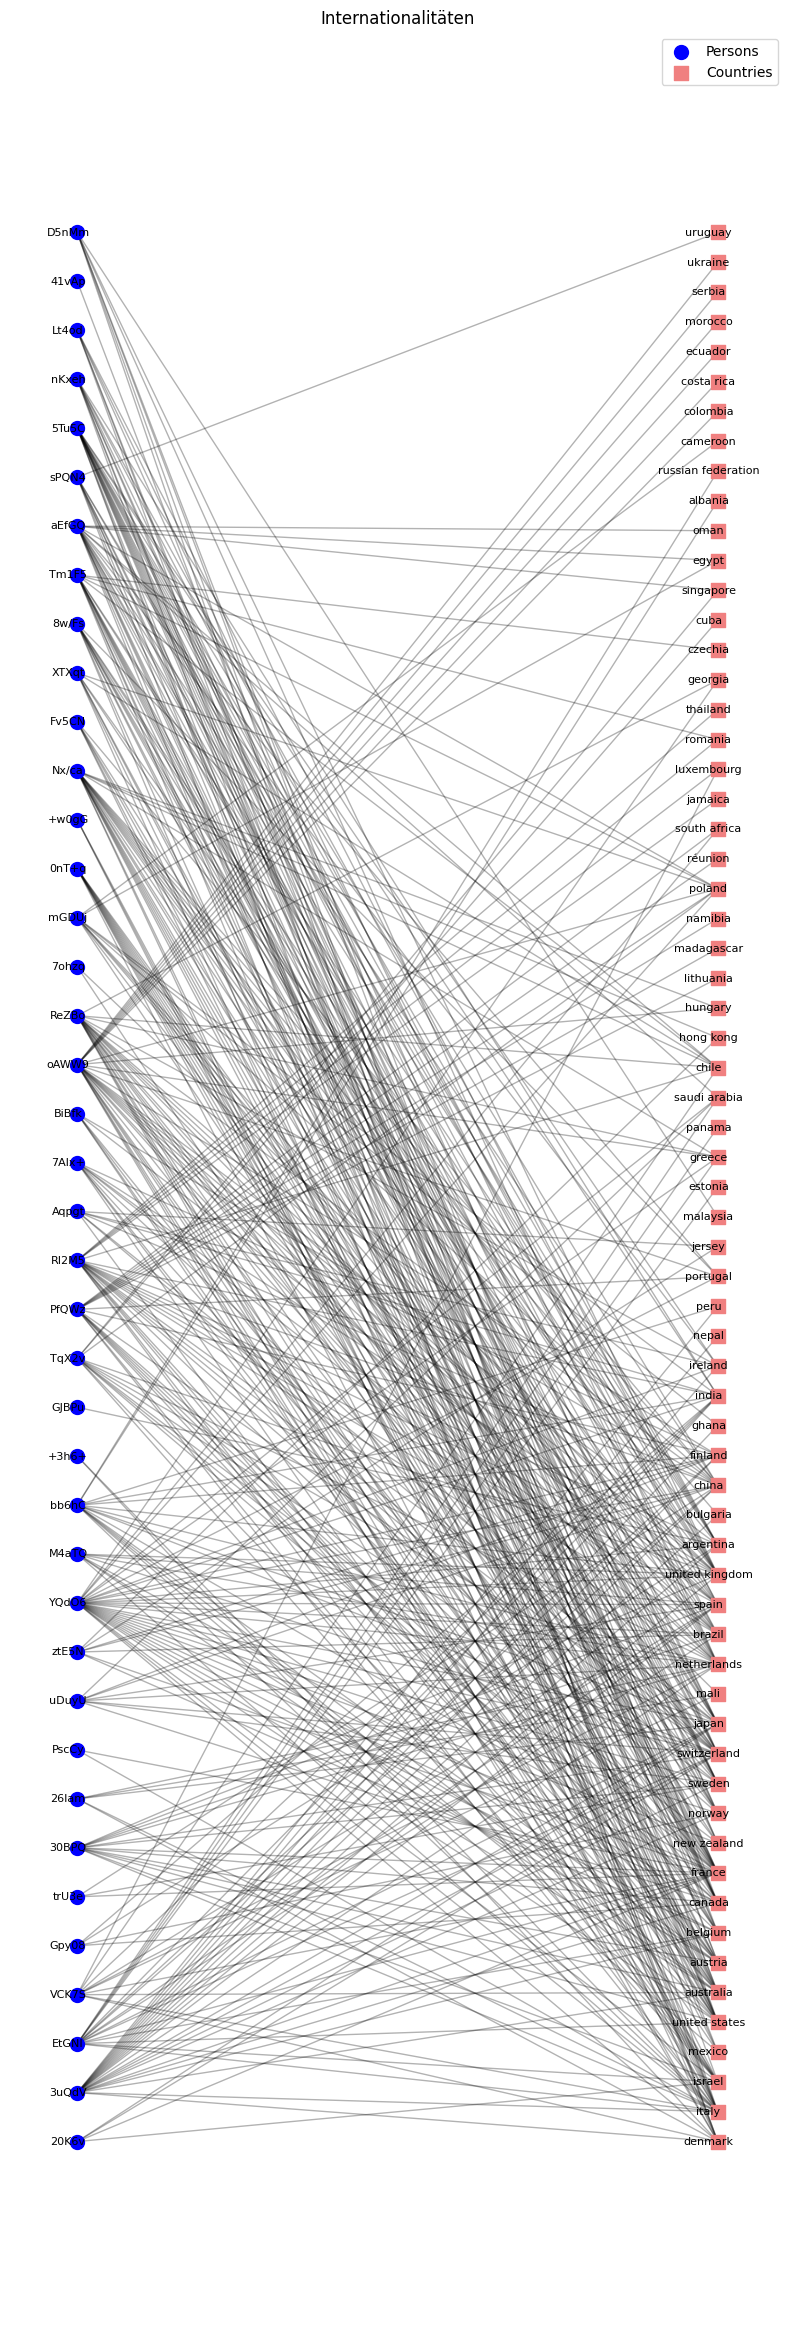

In [15]:
# Bipartite Graphen erstellen für die Darstellung der Internationalen Beziehungen 
# Mit [KI]-Unterstützung erstellt. 

B = nx.Graph()

final_bipartite = final[["source_hashed", "international"]].dropna()
final_bipartite = final_bipartite.rename(columns={"source_hashed": "pi", "international": "country"})
final_bipartite_grouped = final_bipartite.groupby(["pi", "country"]).size().reset_index(name="counts")

# Personen
B.add_nodes_from(final_bipartite_grouped["pi"].unique(), bipartite=0)  # 0 = persons

# Länder
B.add_nodes_from(final_bipartite_grouped["country"].unique(), bipartite=1)  # 1 = countries

for _, row in final_bipartite_grouped.iterrows():
    B.add_edge(row["pi"], row["country"])

persons = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
countries = {n for n, d in B.nodes(data=True) if d["bipartite"] == 1}

pos_bipartite = nx.bipartite_layout(B, persons, align="vertical", scale=3)

plt.figure(figsize=(10, 30))

# Linke Seite der Personen
nx.draw_networkx_nodes(B, pos_bipartite, nodelist=persons,
                        node_color="blue", node_size=100, label="Persons")

# Rechte Seite die Länder
nx.draw_networkx_nodes(B, pos_bipartite, nodelist=countries,
                        node_color="lightcoral", node_size=100,
                        node_shape="s", label="Countries")  

# Verbindungen
nx.draw_networkx_edges(B, pos_bipartite, alpha=0.3)

# Labels:
label_pos = {node: (x-0.07, y) for node, (x, y) in pos_bipartite.items()}
# label_pos_countries = {node: (x+0.07, y) for node, (x, y) in pos_bipartite.items() if node in countries and node in B.nodes()}
# nx.draw_networkx_labels(B, label_pos_persons, font_size=8)  
# nx.draw_networkx_labels(B, label_pos_countries, font_size=8)  
nx.draw_networkx_labels(B, label_pos, font_size=8)

plt.title("Internationalitäten")
plt.legend()
plt.axis("off")
plt.savefig(str(network_dir / f"bipartite_person_country_{datum}.png"), dpi=300)
plt.show()


## Zwischenfazit 

Insgesamt konnte das _affiliation network_ mit den vorhandenen Daten modelliert und dargestellt werden. Verschiedenes hat sich gezeigt: 

- Der Fokus liegt auf den PIs des Fachbereichs und den Instituten, in die sie organisiert sind. Eine Darstellung aller Co-Autorenschaften ist nicht sinnvoll, da es zu viele sind. 
- Die Graphen zeigen durch die Größe der Nodes (entspricht Anzahl Co-Autoren) und die Dicke der Edges (entspricht Anzahl gemeinsamer Publikationen) die kollaborativen Verbindungen innerhalb des Fachbereichs deutlich an.
- Die zentralen Metriken und Visualisierungen ergeben interessante Einsichten in die Struktren. Eine Auswertung erfolgt in der Arbeit in Kapitel _model evaluation_.
- Es ist interessant zu sehen, dass es einige PIs im unteren Bereich gibt und sogar zwei, die singularisiert sind, d.h. keinerlei Verbindungen durch Co-Autorenschaften mit den anderen PIs aufweisen.